# Denpasar Weather Forecasting with TensorFlow

In [22]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (12, 5)
mpl.rcParams['axes.grid'] = False

## The weather dataset

Data collected between 2009-2016 every 10 minutes

In [23]:
usecols = ['dt_iso', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 
           'clouds_all', 'weather_main', 'weather_description']
df = pd.read_csv('openweatherdata-denpasar-1990-2020v0.1.csv', parse_dates=True, usecols=usecols)
df.head()

,dt_iso,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main,weather_description
0,1/1/1990 0:00,25.82,25.82,25.82,1010.0,86,1.36,225,98,Rain,light rain
1,1/1/1990 1:00,26.20,26.20,26.20,1011.0,84,2.09,247,91,Rain,light rain
2,1/1/1990 2:00,26.45,26.45,26.45,1011.0,84,2.44,262,94,Rain,light rain
3,1/1/1990 3:00,26.80,26.80,26.80,1011.0,82,2.29,271,94,Rain,light rain
4,1/1/1990 4:00,27.04,27.04,27.04,1010.0,82,1.71,274,76,Clouds,broken clouds


In [24]:
df.shape

(264924, 11)

**Data Split Function**

In [25]:
# Split the data by percentage
def num_data_train(percentage, data_length):
    num_data = percentage / 100 * data_length
    return int(num_data)

## Forecast a univariate time series

**Split the data**

In [26]:
TRAIN_SPLIT = num_data_train(70, df.shape[0]) # Split 70% of the data for training
tf.random.set_seed(13) # Setting seed to ensure reproducibility
print('Length of Data Train: {}'.format(TRAIN_SPLIT))

Length of Data Train: 185446


In [27]:
# Train a model using a single feature (temperature)
dt_temp = df['temp']
dt_temp.index = df['dt_iso']
dt_temp.tail()

dt_iso
1/7/2020 19:00    27.0
1/7/2020 20:00    27.0
1/7/2020 21:00    28.0
1/7/2020 22:00    28.0
1/7/2020 23:00    28.0
Name: temp, dtype: float64

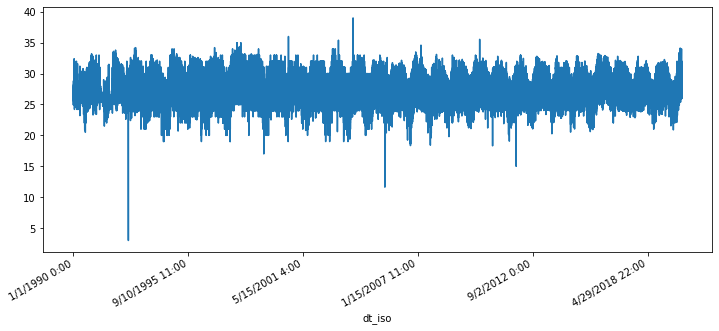

In [45]:
dt_temp.plot(subplots=True)
plt.show()

In [29]:
# Convert the dataframe into numpy array
array_temp = dt_temp.values
print(array_temp[:10]) # Print 10 elements for checking

[25.82 26.2  26.45 26.8  27.04 27.23 27.32 27.29 27.34 27.23]


In [30]:
# Scaling the features
array_temp_mean = array_temp[:TRAIN_SPLIT].mean()
array_temp_std = array_temp[:TRAIN_SPLIT].std()
print('Training Data Mean: {}'.format(array_temp_mean))
print('\nTraining Data Std.Dev: {}'.format(array_temp_std))

Training Data Mean: 27.1836268239811

Training Data Std.Dev: 1.9980058874922433


In [31]:
# Standardize the data
array_temp = (array_temp - array_temp_mean) / array_temp_std
print(array_temp)

[-0.6824939  -0.49230427 -0.36717951 ...  0.40859398  0.40859398
  0.40859398]


In [32]:
# Normalizing the data
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# test_array_temp = dt_temp.values
# test_array_temp.reshape(-1, 1)
# test_array_temp = sc.fit_transform(test_array_temp)
# print('Normalized data:')
# print(test_array_temp[0])

In [33]:
# create a function that return the time windows for the model to train on
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

In this part, the model will be given the last **`n`** recorded temperature observation, and needs to learn to predict the temperature at the next **`m`** time step.

In [34]:
# Create the univariate model
data_past_history = 30 # number of last recorded data (n)
data_future_target = 0 # number of time step (m)

x_train, y_train = univariate_data(array_temp, 0, TRAIN_SPLIT, data_past_history, data_future_target)
x_val, y_val = univariate_data(array_temp, TRAIN_SPLIT, None, data_past_history, data_future_target)

print('Single window of past history:')
print(x_train[0])
print('\n Target temperature to predict:')
print(y_train[0])

Single window of past history:
[[-0.6824939 ]
 [-0.49230427]
 [-0.36717951]
 [-0.19200485]
 [-0.07188509]
 [ 0.02320973]
 [ 0.06825464]
 [ 0.05323967]
 [ 0.07826462]
 [ 0.02320973]
 [ 0.10829456]
 [ 0.07325963]
 [-0.19700984]
 [-0.44725935]
 [-0.56237413]
 [-0.63244399]
 [-0.63744898]
 [-0.65246396]
 [-0.69750887]
 [-0.8326436 ]
 [-1.01782824]
 [-1.0428532 ]
 [-1.03284321]
 [-1.07788813]
 [-1.01782824]
 [-0.99280329]
 [-0.96777834]
 [-0.8326436 ]
 [-0.85766856]
 [-0.75256376]]

 Target temperature to predict:
-0.8076186532194914


In [35]:
def create_time_steps(length):
    return list(range(-length, 0))

In [36]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
       
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\rudyh\\Documents\\Python_Code\\lib\\site-packages\\matplotlib\\pyplot.py'>

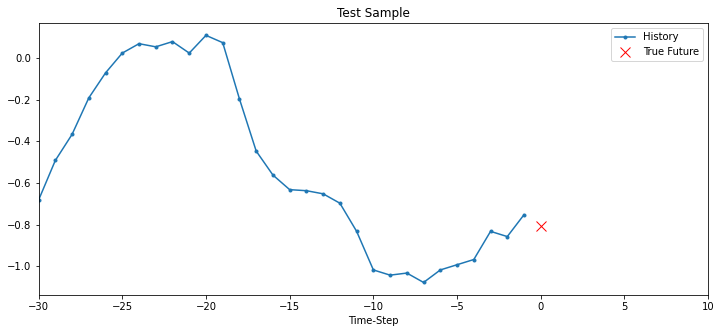

In [37]:
show_plot([x_train[0], y_train[0]], 0, 'Test Sample')

In [38]:
from tensorflow.keras import layers
tf.keras.backend.clear_session()  # For easy reset of notebook state.

# Normal Sequential model
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, input_shape=x_train.shape[-2:]), 
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compare with simple LSTM Model, according to several sources LSTM is suitable for modeling time series data
model_2 = tf.keras.models.Sequential(
    [tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:]), tf.keras.layers.Dense(1)]
)
model_1.summary()
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 16)            32        
_________________________________________________________________
dense_1 (Dense)              (None, 30, 16)            272       
_________________________________________________________________
dense_2 (Dense)              (None, 30, 1)             17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 

In [39]:
# Not worked yet
# model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# Use simple parameter, need more explore in this area
model_1.compile(optimizer='adam', loss='mae')
model_2.compile(optimizer='adam', loss='mae')

**Further reading:**
    
    1. https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
    2. https://stackoverflow.com/questions/45943675/meaning-of-validation-steps-in-keras-sequential-fit-generator-parameter-list/45944225
    3. https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

In [40]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

datatrain = tf.data.Dataset.from_tensor_slices((x_train, y_train))
datatrain = datatrain.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

dataval = tf.data.Dataset.from_tensor_slices((x_val, y_val))
dataval = dataval.batch(BATCH_SIZE).repeat()

In [41]:
# dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# dataset = dataset.batch(32)

# val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# val_dataset = val_dataset.batch(32)

In [42]:
EPOCHS = 10
STEPS_PER_EPOCH = 200 # number of time steps
VALIDATION_STEPS = 50

# Train the model
model_1_history = model_1.fit(datatrain, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=dataval, 
                      validation_steps=VALIDATION_STEPS)
model_2_history = model_2.fit(datatrain, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=dataval, 
                      validation_steps=VALIDATION_STEPS)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 2s 10ms/step - loss: 0.6002 - val_loss: 0.7154
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.8129 - val_loss: 0.7022
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.7974 - val_loss: 0.7008
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6201 - val_loss: 0.7518
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.7549 - val_loss: 0.7077
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.7994 - val_loss: 0.7036
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.7809 - val_loss: 0.7024
Epoch 8/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5791 - val_loss: 0.7198
Epoch 9/10
200/200 [==============================] - 1s 5ms/step - loss: 0.8123 - val_loss: 0.7033
Epoch 10/10
200/200 [==============================] - 1

In [43]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(title)
    plt.legend()
    
    plt.show()

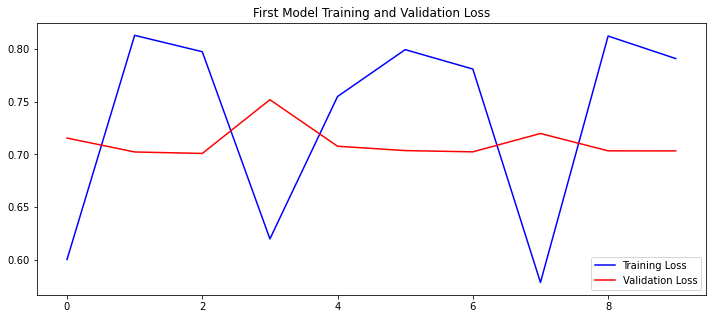

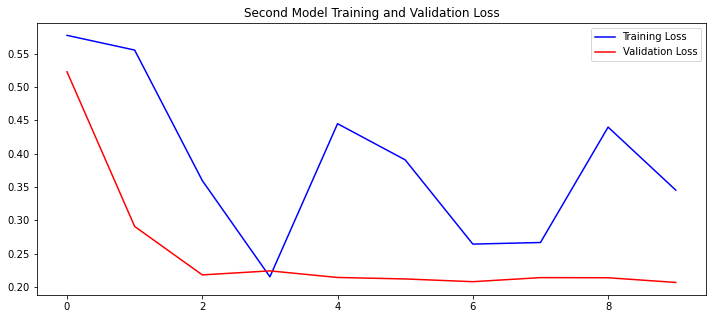

In [44]:
plot_train_history(model_1_history, 'First Model Training and Validation Loss')
plot_train_history(model_2_history, 'Second Model Training and Validation Loss')

**The graph above indicates that the model performance was not really good because we only use single feature (temperature)**
First model is not really clear whether it is overfit or underfit, but the second model clealy underfit. Second model need hyperparameter tuning or because it used only single feature.

In the next section we will use multi-feature/multivariate forecasting.

Further readings:
    1. https://developers.google.com/machine-learning/crash-course/descending-into-ml/training-and-loss
    2. https://stackoverflow.com/questions/48226086/training-loss-and-validation-loss-in-deep-learning

# Multivariate Forecasting